In [1]:
import numpy as np; import matplotlib.pyplot as plt
from matplotlib import colors
import random
import scipy
from scipy.integrate import solve_ivp

import sympy as sym
sym.init_printing()

In [2]:
# Recreation N-P-Z Model - Top Down Limitation
N_T = sym.symbols('N_T') #Total nutrients N + P + Z

N = sym.symbols('N')  # Nutrient supply
K_N = sym.symbols('K_N')  # K_N: is the Monod constant equivalent to the concentration of
# N at which the growth rate is half of its maximum value

P = sym.symbols('P')  # Phytoplankton population density
V_max = sym.symbols('V_max')  # Maximum phytoplankton growth rate
λ_P = sym.symbols('λ_P')  # Mortality & Respiration rate
μ_P = sym.symbols('μ_P')  # Remineralization fraction

Z = sym.symbols('Z')  # Zooplankton population density
g = sym.symbols('g')  # Maximum specific grazing rate
K_P = sym.symbols('K_P')  # Half-Saturation constant for grazing of P
γ_Z = sym.symbols('γ_Z')  # Growth rate / assimilation frequency
λ_Z = sym.symbols('λ_Z')  # Mortality & Respiration & Egestion
μ_Z = sym.symbols('μ_Z')  # Remineralization fraction

In [3]:
# Defining equations
def gamma_P(N, K_N):
    '''Monod growth function for specified nutrient.
       return: Monod (flt)
    '''
    return N / (K_N + N)

def grazing_func(p_pop_den, z_pop_den, grazing_rate, half_sat):
    ''' Grazing function, assuming we are in the linear portion of 
        the monod feeding curve.
        
        return: portion of the phytoplankton population lost to grazing (flt)
    '''
    return grazing_rate * (p_pop_den / (half_sat + p_pop_den)) * z_pop_den


def Gamma_P(pop_den, max_growth_rate, nutr_monod_func, mortality, grazing_func):
    ''' Population density of Phytoplankton over time (steady state)'''
    paren = max_growth_rate * nutr_monod_func - mortality - (grazing_func / pop_den)
    return pop_den * paren

def Gamma_Z(pop_den, growth_rate, grazing_func, mortality):
    ''' Population density of Zooplankton over time (steady state)'''
    paren = growth_rate * (grazing_func / pop_den) - mortality
    return pop_den * paren

def Gamma_N(p_pop_den, max_growth, nutr_monod_func, p_remin, p_mort,
           z_pop_den, z_remin, z_assimilation, grazing_func, z_mort):
    
    '''Nutrient Supply Function'''
    
    from_phyto = p_pop_den * (-max_growth * nutr_monod_func + p_remin * p_mort)
    
    from_zoo_paren = (1 - z_assimilation) * (grazing_func / z_pop_den) + z_mort
    from_zoo = z_pop_den * z_remin * from_zoo_paren
    
    return from_phyto + from_zoo


In [4]:
#Defining equations symbolically with relavent variables
Γ_N = Gamma_N(P, V_max, gamma_P(N, K_N), μ_P, λ_P, Z, μ_Z, γ_Z, grazing_func(P, Z, g, K_P), λ_Z)

Γ_P = Gamma_P(P, V_max, gamma_P(N, K_N), λ_P, grazing_func(P, Z, g, K_P))

Γ_Z = Gamma_Z(Z, γ_Z, grazing_func(P, Z, g, K_P), λ_Z)

# Finding Steady-state solutions

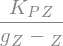

In [5]:
#Threshold for when P population is large enough to sustain Z population
P_sym = sym.solveset(Γ_Z, P)
P_sym = P_sym.args[0].args[0]
P_sol = sym.lambdify((N_T, K_N, V_max, λ_P, μ_P, g, K_P, γ_Z, λ_Z, μ_Z), P_sym)

P_sym

# Method 1: Find Z from Γ_P, Find N in terms of total nutrients.

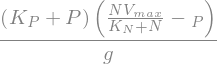

In [6]:
#Symbolically solving for Z from Gamma_P
Z_sym = sym.solveset(Γ_P, Z)

#Turning into usable function
Z_sym = Z_sym.args[0]
Z_sol = sym.lambdify((N_T, K_N, V_max, λ_P, μ_P, g, K_P, γ_Z, λ_Z, μ_Z), Z_sym)
Z_sym 

We know from $N_T = N + P + Z(N) \quad \Rightarrow \quad N + Z(N) + P - N_T = 0$


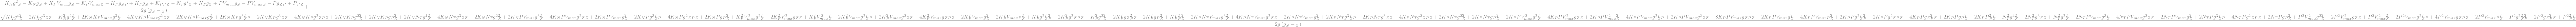

In [7]:
#Solving for N in terms of N_T 
N_sym = sym.solveset(N + Z_sym + P_sym - N_T, N)
N_sym = N_sym.args[0].args[1]

#Turning into usable function, using positive branch of sol
N_sol = sym.lambdify((N_T, P, K_N, V_max, λ_P, μ_P, g, K_P, γ_Z, λ_Z, μ_Z), N_sym)
N_sym

# Plotting 

In [8]:
#Plotting Regimes
def regime(N, K_N, V_max, λ_P, μ_P, g, K_P, γ_Z, λ_Z, μ_Z):

    #N-Regime
    N_threshold = λ_P * K_N / (V_max - λ_P)
    
    if N < N_threshold: 
        N_n = N
        P, Z = 0, 0
        
        
    #N-P Regime
    else:
        P = N - N_threshold
        N_n = N - P
        P_threshold = P_sol(N, K_N, V_max, λ_P, μ_P, g, K_P, γ_Z, λ_Z, μ_Z)
        
        if P < P_threshold:
            Z = 0
        
        #N-P-Z Regime
        else:
            P = P_threshold

            N_n = N_sol(N, P, K_N, V_max, λ_P, μ_P, g, K_P, γ_Z, λ_Z, μ_Z)
            Z = N - P - N_n
            
    return N_n, P, Z
    

#Args
K_N = .1    #mmol m^-3, the concentration of nutrients that supports a phytoplankton growthrate of V_max/2

V_max = 1.4 #d^-1
λ_P = .05   #d^-1
μ_P = .4

g = 1.4     #d^-1 
K_P = 2.8   #mmol m^-3, the concentration of phytoplankton that supports a grazing rate of g/2
γ_Z = .4
λ_Z = .12   #d^-1
μ_Z = .4

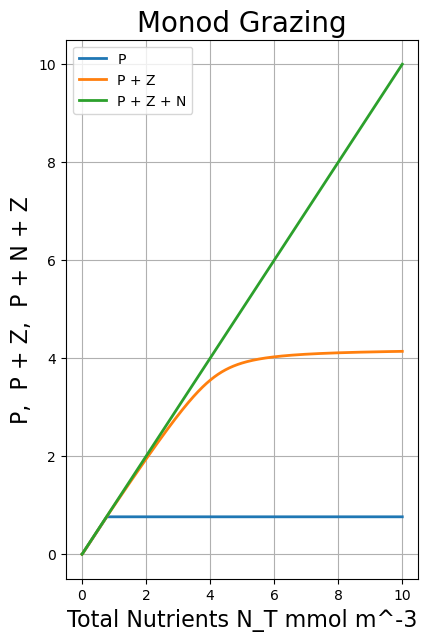

In [13]:
N_T = np.arange(0, 10, .0001)

#Computing variable values
N = [regime(N_T[i], K_N, V_max, λ_P, μ_P, g, K_P, γ_Z, λ_Z, μ_Z)[0] for i in range(len(N_T))]
P = [regime(N_T[i], K_N, V_max, λ_P, μ_P, g, K_P, γ_Z, λ_Z, μ_Z)[1] for i in range(len(N_T))]
Z = [regime(N_T[i], K_N, V_max, λ_P, μ_P, g, K_P, γ_Z, λ_Z, μ_Z)[2] for i in range(len(N_T))]

P_Z_sum = [P[i] + Z[i] for i in range(len(N_T))]
N_P_Z_sum = [N[i] + P[i] + Z[i] for i in range(len(N_T))]

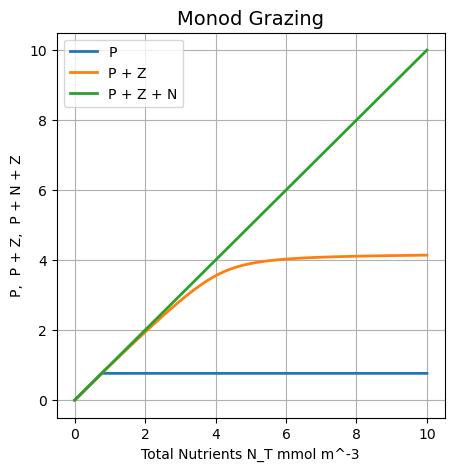

In [17]:
#Plotting
fig = plt.figure(figsize=(11,5))
ax = fig.add_subplot(121)

#N-P-Z
ax.plot(N_T, P, linewidth = 2, label="P")
ax.plot(N_T, P_Z_sum, linewidth = 2, label="P + Z")
ax.plot(N_T, N_P_Z_sum, linewidth = 2, label="P + Z + N")

ax.set_xlabel("Total Nutrients N_T mmol m^-3")
ax.set_ylabel("P,  P + Z,  P + N + Z")
ax.set_title("Monod Grazing", fontsize=14)

ax.legend()
ax.grid()

plt.show()

In [10]:
#Random rgb tuple generator 
def rand_color():
    r = random.random()
    g = random.random()
    b = random.random()
    return (r, g, b)

In [11]:
#Messing with grazing rate
grazing_rates = [.6, 1, 1.4, 1.8, 2.2]

#Creates a dictionary; Keys: grazing rates, Defs: regime solutions at rate
grazing_values = {}
for rate in grazing_rates:
    
    #Generating state variable values
    N = [regime(N_T[i], K_N, V_max, λ_P, μ_P, rate, K_P, γ_Z, λ_Z, μ_Z)[0] for i in range(len(N_T))]
    P = [regime(N_T[i], K_N, V_max, λ_P, μ_P, rate, K_P, γ_Z, λ_Z, μ_Z)[1] for i in range(len(N_T))]
    Z = [regime(N_T[i], K_N, V_max, λ_P, μ_P, rate, K_P, γ_Z, λ_Z, μ_Z)[2] for i in range(len(N_T))]

    #Generating sum as defined in Sermiento
    P_Z_sum = [P[i] + Z[i] for i in range(len(N_T))]
    N_P_Z_sum = [N[i] + P[i] + Z[i] for i in range(len(N_T))]
    
    grazing_values[rate] = (P, P_Z_sum, N_P_Z_sum, rand_color())

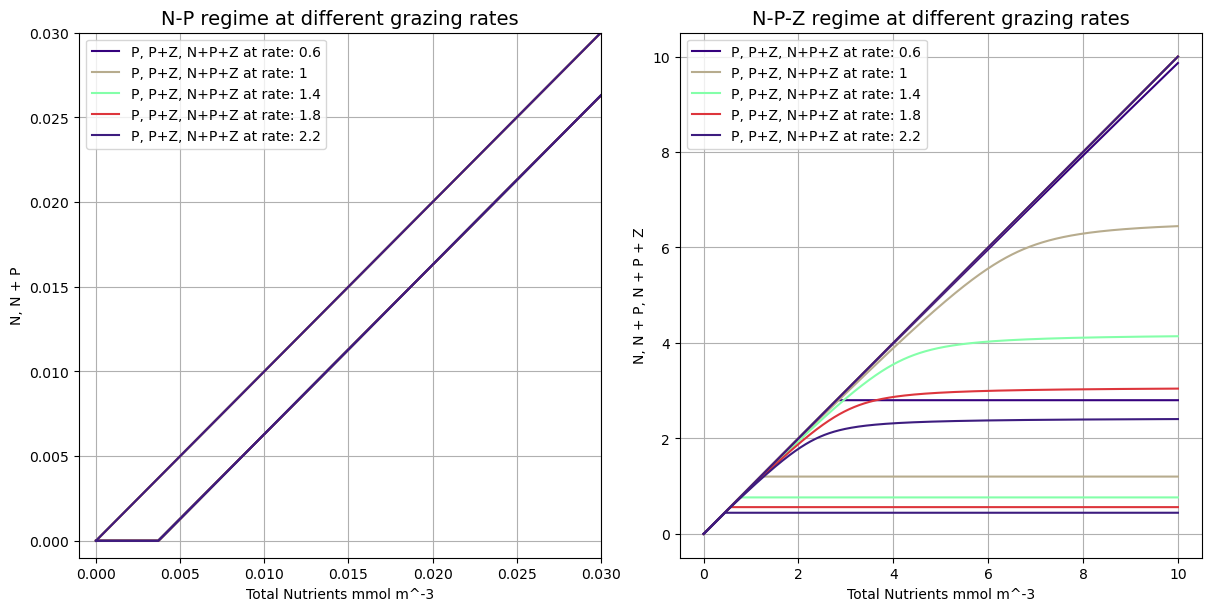

In [12]:
sol = grazing_values
fig = plt.figure(constrained_layout=True, figsize=(12,6))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for rate in sol:

    ax.plot(N_T, sol[rate][0], color=sol[rate][3], linewidth = 1.5, label="P, P+Z, N+P+Z at rate: " + str(rate))
    ax.plot(N_T, sol[rate][1], color=sol[rate][3], linewidth = 1.5)
    ax.plot(N_T, sol[rate][2], color=sol[rate][3], linewidth = 1.5)

    ax.set_xlim([-.001, .03]); ax.set_ylim([-.001, .03])
    ax.set_xlabel('Total Nutrients mmol m^-3')
    ax.set_ylabel('N, N + P')
    ax.set_title('N-P regime at different grazing rates', fontsize = 14)

    ax2.plot(N_T, sol[rate][0], color=sol[rate][3], linewidth = 1.5, label="P, P+Z, N+P+Z at rate: " + str(rate))
    ax2.plot(N_T, sol[rate][1], color=sol[rate][3], linewidth = 1.5)
    ax2.plot(N_T, sol[rate][2], color=sol[rate][3], linewidth = 1.5)

    ax2.set_xlabel('Total Nutrients mmol m^-3')
    ax2.set_ylabel('N, N + P, N + P + Z')
    ax2.set_title('N-P-Z regime at different grazing rates', fontsize = 14)

ax.legend(); ax.grid()
ax2.legend(); ax2.grid()